# Customer Lifetime Value (CLV) Analysis

This notebook analyzes product performance by subcategory and geographical region using different Customer Lifetime Value (CLV) metrics.

## Key CLV Metrics Explained

1. **Traditional CLV**: Average revenue a customer generates over their relationship with your business for a specific product/category.
   Formula: Average Sales per Customer × Average Number of Orders

2. **Profit-Adjusted CLV**: Accounts for varying profit margins across products.
   Formula: Traditional CLV × Profit Margin

3. **Discount-Adjusted CLV**: Factors in how sensitive customers are to discounts.
   Formula: Traditional CLV × (1 - (Discount Sensitivity × Average Discount))

4. **Composite CLV**: Combines both profit margin and discount sensitivity.
   Formula: Profit-Adjusted CLV × (1 - (Discount Sensitivity × Average Discount))

5. **Discount Sensitivity**: Correlation between discount rates and purchase quantity. 
   - Positive values: Products sell better when discounted
   - Negative values: Products don't benefit from or sell worse with discounts

In [127]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seaborn style for better Jupyter display
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [ ]:
# Load the dataset
ecom = pd.read_csv('superstore.csv', encoding='latin-1')

ecom.columns = ecom.columns.str.lower().str.replace(' ', '_', regex=True)
ecom['order_date'] = pd.to_datetime(ecom['order_date'])
ecom['ship_date'] = pd.to_datetime(ecom['ship_date'])


In [129]:
# Calculate metrics needed for CLV analysis
# Step 1: Calculate profit margin and organize data by product & customer
ecom['profit_margin'] = ecom['profit'] / ecom['sales']

# Group by product and customer
product_customer = ecom.groupby(['product_id', 'customer_id']).agg({
    'sales': 'sum',
    'profit': 'sum',
    'order_id': 'nunique',
    'order_date': 'max'
}).reset_index()

product_customer['profit_margin'] = product_customer['profit'] / product_customer['sales']


In [130]:
# Step 2: Calculate product-level metrics
product_clv = product_customer.groupby('product_id').agg({
    'sales': 'mean',
    'profit_margin': 'mean',
    'order_id': 'mean',
    'customer_id': 'nunique'
}).reset_index()

product_clv['traditional_clv'] = product_clv['sales'] * product_clv['order_id']
product_clv['profit_adjusted_clv'] = product_clv['traditional_clv'] * product_clv['profit_margin']


In [145]:
# Step 3: Calculate discount sensitivity
discount_sensitivity = []
for product in ecom['product_id'].unique():
    product_data = ecom[ecom['product_id'] == product]
    if product_data.shape[0] > 1:
        correlation = product_data['discount'].corr(product_data['quantity'])
        discount_sensitivity.append({
            'product_id': product,
            'discount_sensitivity': correlation if not np.isnan(correlation) else 0
        })

discount_df = pd.DataFrame(discount_sensitivity)
avg_discount = ecom.groupby('product_id')['discount'].mean().reset_index()
avg_discount.rename(columns={'discount': 'avg_discount'}, inplace=True)

/opt/anaconda3/envs/CAB_V1/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/CAB_V1/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [146]:
# Calculate average discount for each product
avg_discount = ecom.groupby('product_id')['discount'].mean().reset_index()
avg_discount.rename(columns={'discount': 'avg_discount'}, inplace=True)

# Create discount_df if not defined already
discount_df = ecom.groupby('product_id').apply(
    lambda x: pd.Series({
        'discount_sensitivity': np.corrcoef(x['discount'], x['quantity'])[0, 1] 
        if len(x) > 1 else 0
    })
).reset_index()

# Step 4: Combine all metrics
discount_data = pd.merge(discount_df, avg_discount, on='product_id', how='left')
discount_clv = pd.merge(discount_data, 
                        product_clv[['product_id', 'traditional_clv']], 
                        on='product_id', how='left')
discount_clv['discount_adjusted_clv'] = discount_clv['traditional_clv'] * \
                                       (1 - (discount_clv['discount_sensitivity'] * discount_clv['avg_discount']))

# Combine all data
combined_clv = pd.merge(
    product_clv[['product_id', 'traditional_clv', 'profit_adjusted_clv', 'profit_margin']], 
    discount_clv[['product_id', 'discount_adjusted_clv', 'discount_sensitivity', 'avg_discount']],
    on='product_id', how='left'
)

# Add product info
product_info = ecom[['product_id', 'product_name', 'category', 'sub-category']].drop_duplicates()
combined_clv = pd.merge(combined_clv, product_info, on='product_id', how='left')
combined_clv['composite_clv'] = combined_clv['profit_adjusted_clv'] * \
                              (1 - (combined_clv['discount_sensitivity'] * combined_clv['avg_discount']))

/opt/anaconda3/envs/CAB_V1/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/CAB_V1/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/ms/kffv8scn23l62n_5h2kgw9sw0000gn/T/ipykernel_1220/2580693072.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  discount_df = ecom.groupby('product_id').apply(


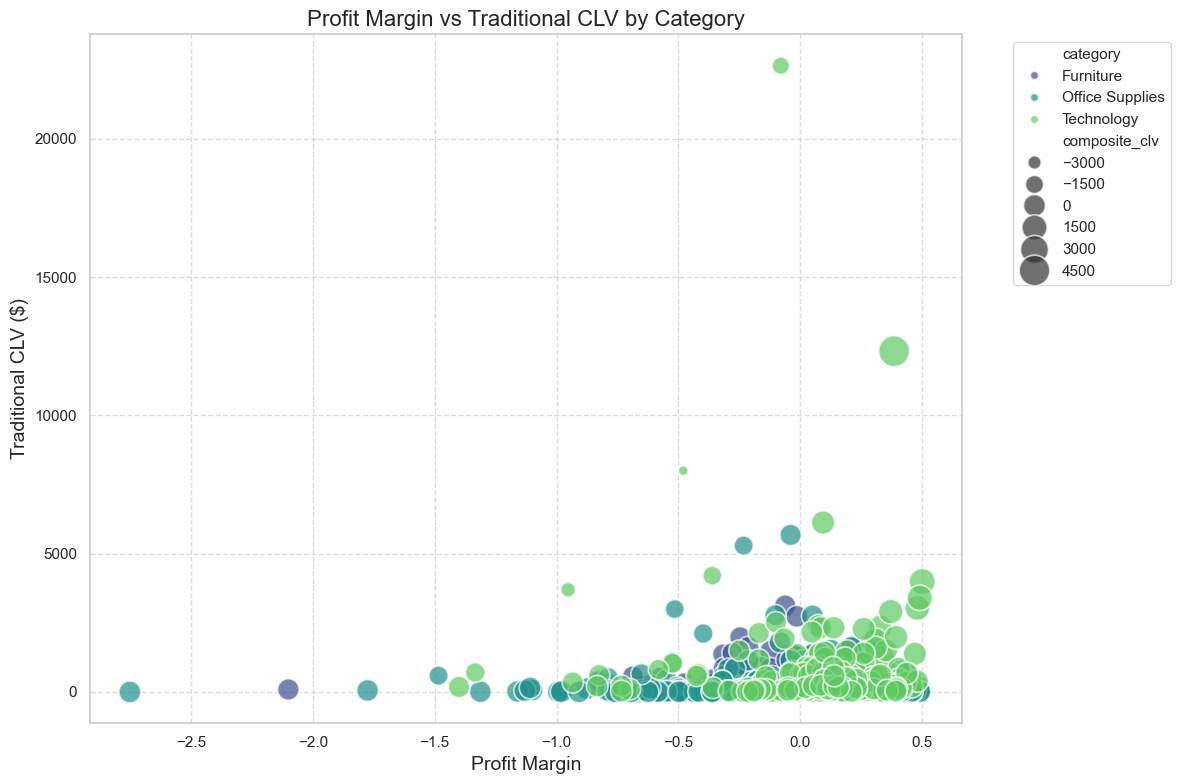

In [133]:
# Create visualizations

# 1. Profit Margin vs CLV by Category (with improved styling for Jupyter)
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    x='profit_margin', 
    y='traditional_clv',
    hue='category',
    size='composite_clv',
    sizes=(50, 500),
    alpha=0.7,
    palette='viridis',
    data=combined_clv
)

# Format for better Jupyter display
scatter.set_title('Profit Margin vs Traditional CLV by Category', fontsize=16)
scatter.set_xlabel('Profit Margin', fontsize=14)
scatter.set_ylabel('Traditional CLV ($)', fontsize=14)
scatter.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()  # Explicitly show the plot in Jupyter


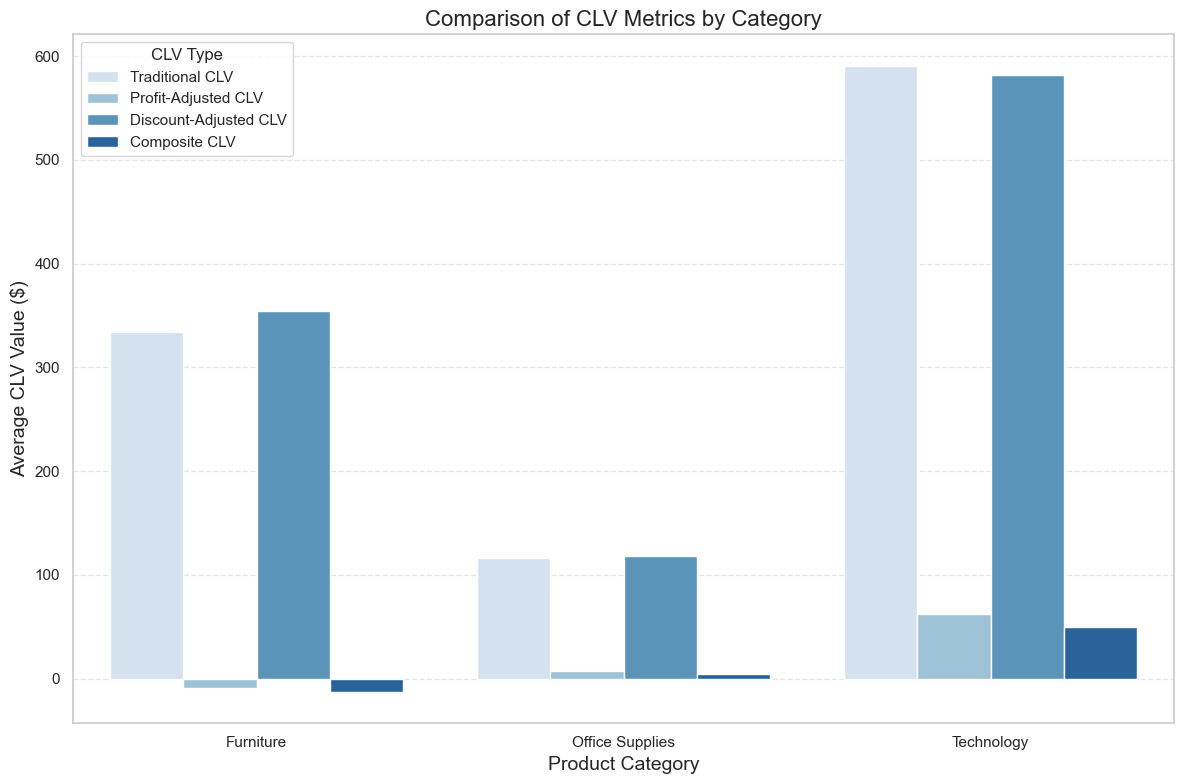

In [134]:
# 2. Category Comparison - Bar Plot with confidence intervals
plt.figure(figsize=(12, 8))
category_clv = combined_clv.groupby('category').agg({
    'traditional_clv': 'mean',
    'profit_adjusted_clv': 'mean',
    'discount_adjusted_clv': 'mean',
    'composite_clv': 'mean'
}).reset_index()

category_melted = pd.melt(
    category_clv, 
    id_vars=['category'],
    value_vars=['traditional_clv', 'profit_adjusted_clv', 'discount_adjusted_clv', 'composite_clv'],
    var_name='clv_type', 
    value_name='value'
)

# Map variable names to more readable labels
category_melted['clv_type'] = category_melted['clv_type'].map({
    'traditional_clv': 'Traditional CLV',
    'profit_adjusted_clv': 'Profit-Adjusted CLV',
    'discount_adjusted_clv': 'Discount-Adjusted CLV',
    'composite_clv': 'Composite CLV'
})

bar = sns.barplot(
    x='category', 
    y='value', 
    hue='clv_type', 
    data=category_melted,
    palette='Blues'
)

bar.set_title('Comparison of CLV Metrics by Category', fontsize=16)
bar.set_xlabel('Product Category', fontsize=14)
bar.set_ylabel('Average CLV Value ($)', fontsize=14)
bar.tick_params(axis='x', rotation=0)
plt.legend(title='CLV Type')
plt.grid(True, linestyle='--', alpha=0.5, axis='y')
plt.tight_layout()
plt.show()


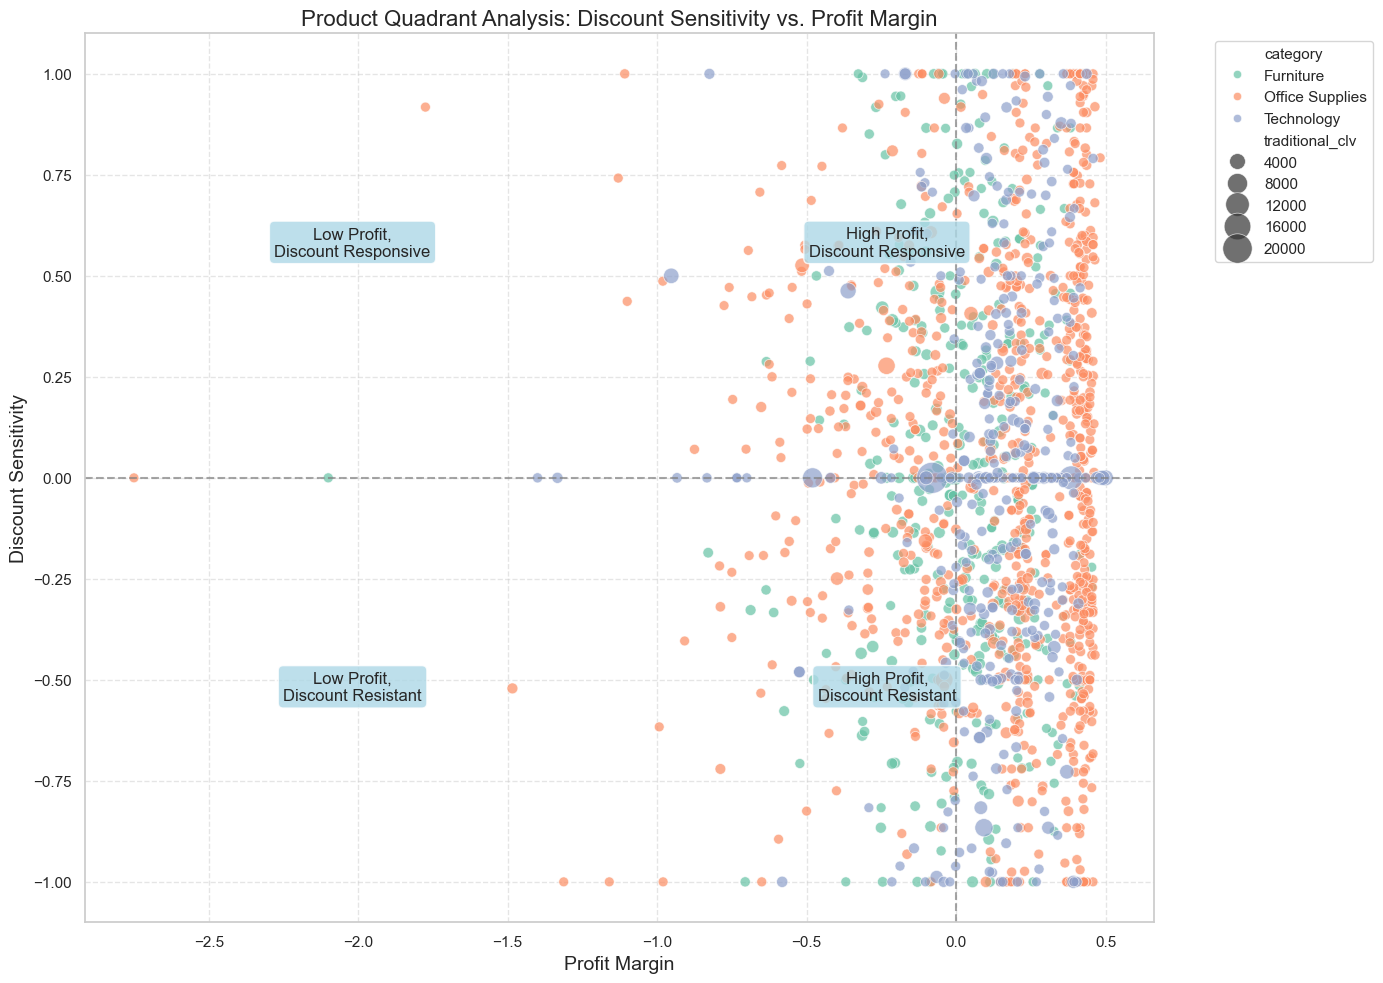

In [135]:
# 3. Quadrant Analysis - Discount Sensitivity vs. Profit Margin
plt.figure(figsize=(14, 10))
quadrant = sns.scatterplot(
    x='profit_margin',
    y='discount_sensitivity',
    hue='category',
    size='traditional_clv',
    sizes=(50, 500),
    alpha=0.7,
    palette='Set2',
    data=combined_clv
)

# Add quadrant lines
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)

# Add quadrant labels with better styling
plt.annotate('High Profit,\nDiscount Responsive', xy=(0.75, 0.75), xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)
plt.annotate('Low Profit,\nDiscount Responsive', xy=(0.25, 0.75), xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)
plt.annotate('High Profit,\nDiscount Resistant', xy=(0.75, 0.25), xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)
plt.annotate('Low Profit,\nDiscount Resistant', xy=(0.25, 0.25), xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)

quadrant.set_title('Product Quadrant Analysis: Discount Sensitivity vs. Profit Margin', fontsize=16)
quadrant.set_xlabel('Profit Margin', fontsize=14)
quadrant.set_ylabel('Discount Sensitivity', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


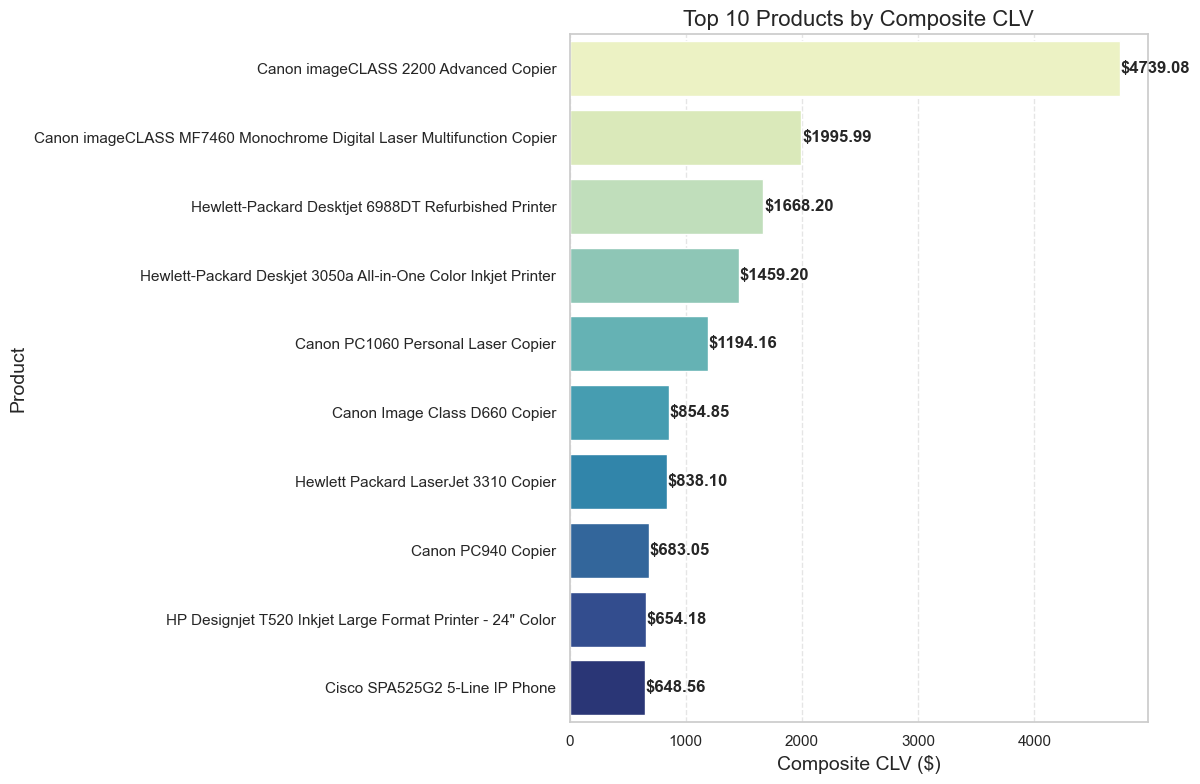

In [136]:
# 4. Top 10 Products by Composite CLV
top10 = combined_clv.sort_values('composite_clv', ascending=False).head(10)
plt.figure(figsize=(12, 8))

# Create horizontal bar chart with updated styling to fix the warning
top10_plot = sns.barplot(
    y='product_name',
    x='composite_clv',
    hue='product_name',  # Add this line to address the warning
    data=top10,
    palette='YlGnBu',
    orient='h',
    legend=False  # Hide the legend since we don't need it
)

# Add value labels to the end of each bar
for i, v in enumerate(top10['composite_clv']):
    top10_plot.text(v + 5, i, f'${v:.2f}', va='center', fontweight='bold')

top10_plot.set_title('Top 10 Products by Composite CLV', fontsize=16)
top10_plot.set_xlabel('Composite CLV ($)', fontsize=14)
top10_plot.set_ylabel('Product', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5, axis='x')
plt.tight_layout()
plt.show()

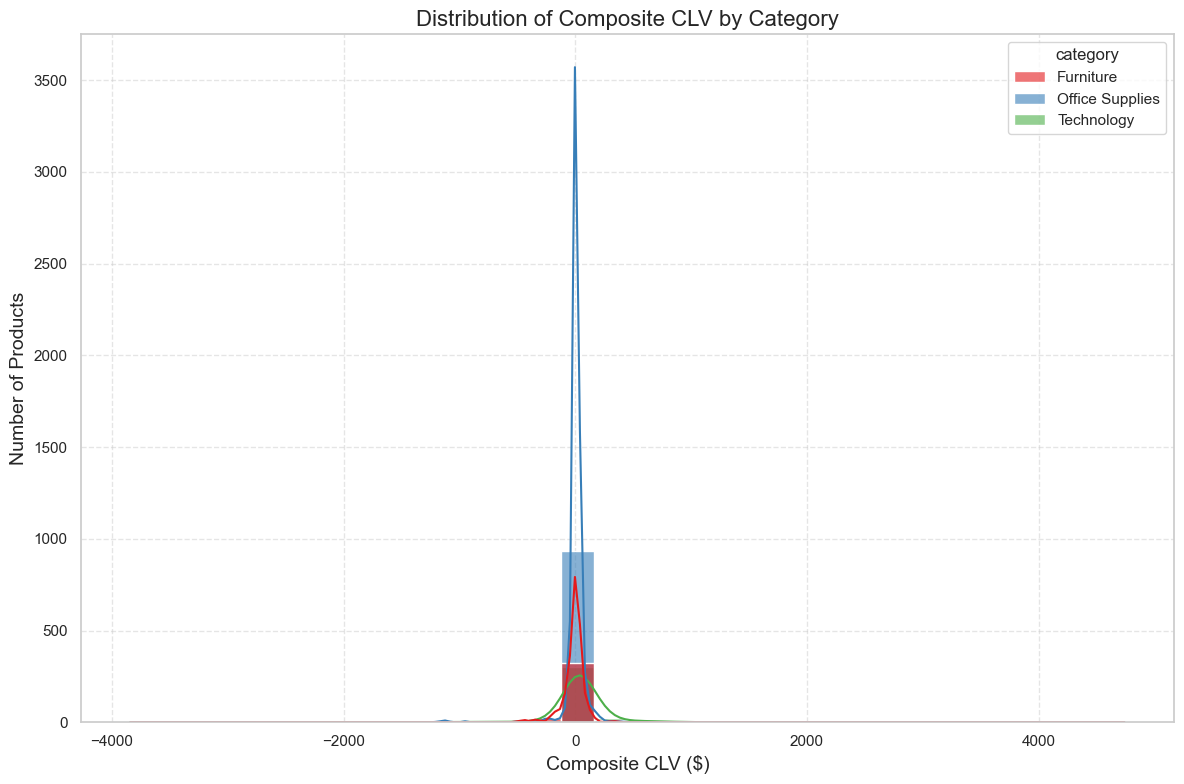

In [137]:
# 5. Distribution of CLV Values with KDE
plt.figure(figsize=(12, 8))
dist = sns.histplot(
    data=combined_clv,
    x='composite_clv',
    hue='category',
    kde=True,
    bins=30,
    alpha=0.6,
    palette='Set1'
)

dist.set_title('Distribution of Composite CLV by Category', fontsize=16)
dist.set_xlabel('Composite CLV ($)', fontsize=14)
dist.set_ylabel('Number of Products', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Subcategory Analysis

Analyzing CLV at the subcategory level helps identify which specific product types drive the most customer value.
This allows for targeted inventory, pricing, and marketing decisions by subcategory.

In [138]:
# SUBCATEGORY ANALYSIS
# Group data by subcategory and customer
subcategory_customer = ecom.groupby(['sub-category', 'customer_id']).agg({
    'sales': 'sum',
    'profit': 'sum',
    'order_id': 'nunique',
    'discount': 'mean'
}).reset_index()

# Calculate profit margin
subcategory_customer['profit_margin'] = subcategory_customer['profit'] / subcategory_customer['sales']

# Calculate metrics by subcategory
subcategory_metrics = subcategory_customer.groupby('sub-category').agg({
    'customer_id': 'nunique',  # Number of customers
    'sales': 'mean',           # Average sales per customer
    'profit': 'mean',          # Average profit per customer
    'profit_margin': 'mean',   # Average profit margin
    'order_id': 'mean',        # Average orders per customer
    'discount': 'mean'         # Average discount
}).reset_index()

# Calculate traditional CLV
subcategory_metrics['traditional_clv'] = subcategory_metrics['sales'] * subcategory_metrics['order_id']

# Calculate profit-adjusted CLV
subcategory_metrics['profit_adjusted_clv'] = subcategory_metrics['traditional_clv'] * subcategory_metrics['profit_margin']

# Calculate discount sensitivity
discount_sensitivity = []
for subcat in ecom['sub-category'].unique():
    subcat_data = ecom[ecom['sub-category'] == subcat]
    if subcat_data.shape[0] > 1:
        correlation = subcat_data['discount'].corr(subcat_data['quantity'])
        discount_sensitivity.append({
            'sub-category': subcat,
            'discount_sensitivity': correlation if not np.isnan(correlation) else 0
        })

discount_df = pd.DataFrame(discount_sensitivity)
subcategory_metrics = pd.merge(subcategory_metrics, discount_df, on='sub-category', how='left')

# Add category information
category_info = ecom[['sub-category', 'category']].drop_duplicates()
subcategory_metrics = pd.merge(subcategory_metrics, category_info, on='sub-category', how='left')

# Calculate composite CLV
subcategory_metrics['composite_clv'] = subcategory_metrics['profit_adjusted_clv'] * \
                                     (1 - (subcategory_metrics['discount_sensitivity'] * subcategory_metrics['discount']))

In [139]:
# State analysis 
# Group data by state and customer
state_customer = ecom.groupby(['state', 'customer_id']).agg({
    'sales': 'sum',
    'profit': 'sum',
    'order_id': 'nunique',
    'discount': 'mean'
}).reset_index()

# Calculate profit margin with error handling
state_customer['profit_margin'] = np.where(
    state_customer['sales'] > 0,
    state_customer['profit'] / state_customer['sales'],
    0  # Default value when sales is 0
)

# Calculate metrics by state
state_metrics = state_customer.groupby('state').agg({
    'customer_id': 'nunique',  # Number of customers
    'sales': 'mean',           # Average sales per customer
    'profit': 'mean',          # Average profit per customer
    'profit_margin': 'mean',   # Average profit margin
    'order_id': 'mean',        # Average orders per customer
    'discount': 'mean'         # Average discount
}).reset_index()

# Calculate traditional CLV
state_metrics['traditional_clv'] = state_metrics['sales'] * state_metrics['order_id']

# Calculate profit-adjusted CLV
state_metrics['profit_adjusted_clv'] = state_metrics['traditional_clv'] * state_metrics['profit_margin']

# Calculate discount sensitivity - improved version
state_discount_sensitivity = []
for state in ecom['state'].unique():
    state_data = ecom[ecom['state'] == state]
    # Only calculate correlation if we have enough data points and valid values
    if state_data.shape[0] > 10:  # Increased minimum sample size for more reliable correlation
        # Filter out any NaN values
        valid_data = state_data.dropna(subset=['discount', 'quantity'])
        # Check if there's variation in the data (to avoid division by zero)
        if valid_data['discount'].std() > 0 and valid_data['quantity'].std() > 0:
            correlation = valid_data['discount'].corr(valid_data['quantity'])
            state_discount_sensitivity.append({
                'state': state,
                'discount_sensitivity': correlation
            })
        else:
            # If no variation, set correlation to 0
            state_discount_sensitivity.append({
                'state': state,
                'discount_sensitivity': 0
            })
    else:
        # Not enough data points
        state_discount_sensitivity.append({
            'state': state,
            'discount_sensitivity': 0
        })

# Convert to DataFrame
state_discount_df = pd.DataFrame(state_discount_sensitivity)

# Merge with state metrics
state_metrics = pd.merge(state_metrics, state_discount_df, on='state', how='left')

# Calculate composite CLV with NaN handling
state_metrics['composite_clv'] = state_metrics['profit_adjusted_clv'] * \
                               (1 - (state_metrics['discount_sensitivity'].fillna(0) * state_metrics['discount']))

# Add region information
region_info = ecom[['state', 'region']].drop_duplicates()
state_metrics = pd.merge(state_metrics, region_info, on='state', how='left')

### 1. Traditional CLV by Subcategory
    
    This bar chart ranks subcategories by Traditional CLV, colored by their main category.
    
    **What it shows:**
    - Which subcategories generate the highest customer lifetime value
    - How subcategories within the same main category compare to each other
    - The relative value spread across your product range
    
    **Business applications:**
    - Prioritize high-CLV subcategories in marketing and inventory
    - Identify underperforming subcategories that may need attention
    - Compare category performance across the product mix

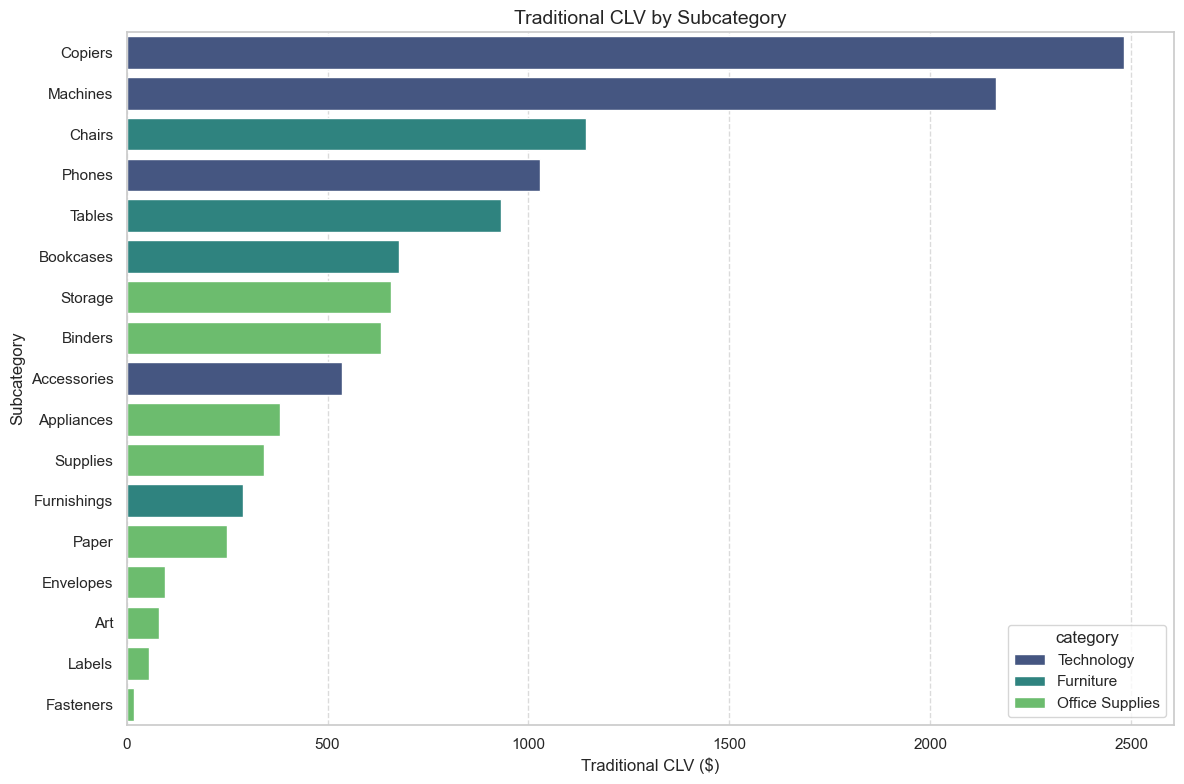

In [140]:
# 1. Subcategory CLV comparison
plt.figure(figsize=(12, 8))
sns.barplot(
        x='traditional_clv', 
        y='sub-category',
        hue='category',
        data=subcategory_metrics.sort_values('traditional_clv', ascending=False),
        palette='viridis'
    )
plt.title('Traditional CLV by Subcategory', fontsize=14)
plt.xlabel('Traditional CLV ($)', fontsize=12)
plt.ylabel('Subcategory', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7, axis='x')
plt.tight_layout()
plt.show()  # This displays the plot directly in VS Code


### 2. Subcategory Quadrant Analysis
    
    This scatter plot positions each subcategory based on its profit margin and discount sensitivity.
    
    **What it shows:**
    - Four strategic quadrants:
      1. Top-Right: High profit, discount responsive (ideal for promotions)
      2. Bottom-Right: High profit, discount resistant (premium pricing)
      3. Top-Left: Low profit, discount responsive (potential issues)
      4. Bottom-Left: Low profit, discount resistant (reconsider these products)
    - Bubble size represents Traditional CLV
    
    **Business applications:**
    - Identify which subcategories to promote with discounts
    - Find profitable subcategories that can maintain premium pricing
    - Recognize problematic subcategories that may need strategy changes

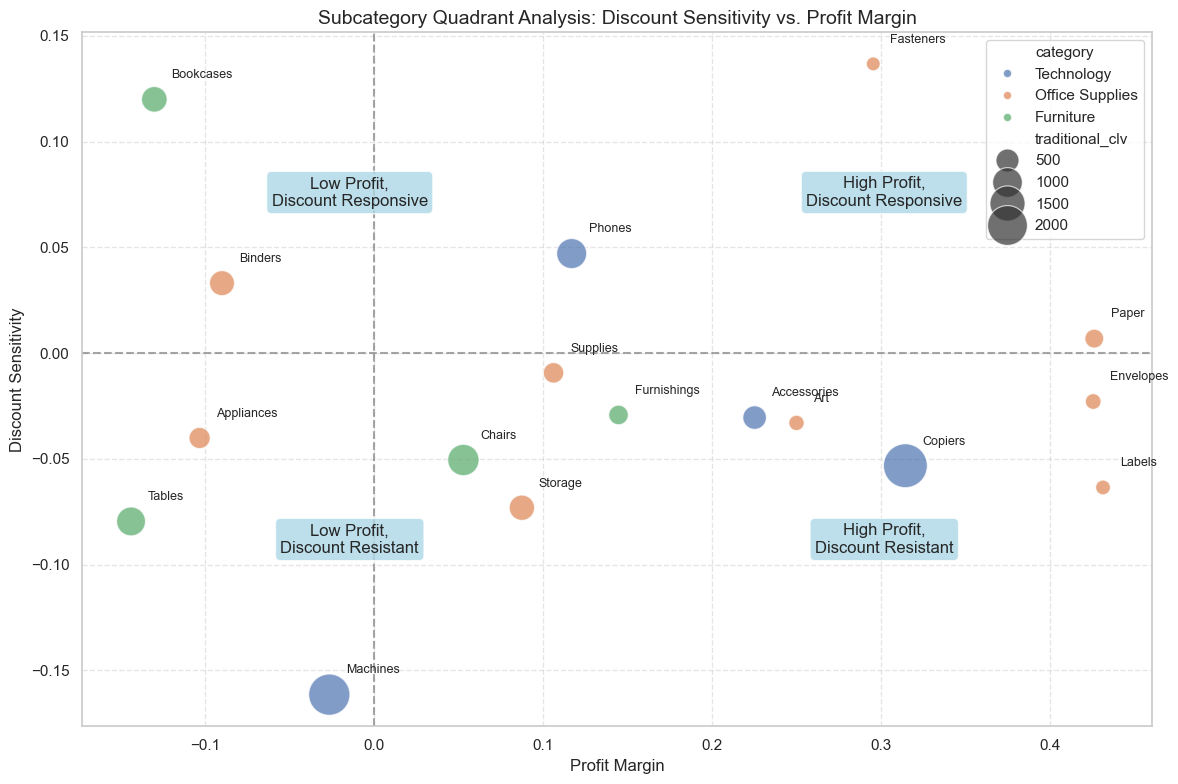

In [141]:
# 2. Subcategory Quadrant Analysis
plt.figure(figsize=(12, 8))
sns.scatterplot(
        x='profit_margin',
        y='discount_sensitivity',
        size='traditional_clv',
        hue='category',
        sizes=(100, 1000),
        alpha=0.7,
        data=subcategory_metrics
    )

# Add quadrant lines
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)

# Add labels for each subcategory
for i, row in subcategory_metrics.iterrows():
        plt.text(row['profit_margin'] + 0.01, 
                row['discount_sensitivity'] + 0.01, 
                row['sub-category'], 
                fontsize=9)

# Add quadrant labels
plt.annotate('High Profit,\nDiscount Responsive', xy=(0.75, 0.75), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)
plt.annotate('Low Profit,\nDiscount Responsive', xy=(0.25, 0.75), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)
plt.annotate('High Profit,\nDiscount Resistant', xy=(0.75, 0.25), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)
plt.annotate('Low Profit,\nDiscount Resistant', xy=(0.25, 0.25), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)

plt.title('Subcategory Quadrant Analysis: Discount Sensitivity vs. Profit Margin', fontsize=14)
plt.xlabel('Profit Margin', fontsize=12)
plt.ylabel('Discount Sensitivity', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()  # This displays the plot directly in VS Code


### 3. Top 10 States by Composite CLV
    
    This bar chart shows the states with the highest composite CLV, colored by region.
    
    **What it shows:**
    - Which states provide the highest customer value when accounting for both profit margin and discount sensitivity
    - How these high-value states distribute across different regions
    
    **Business applications:**
    - Target marketing efforts in high-CLV states
    - Identify regional patterns in customer value
    - Optimize sales territories based on CLV potential

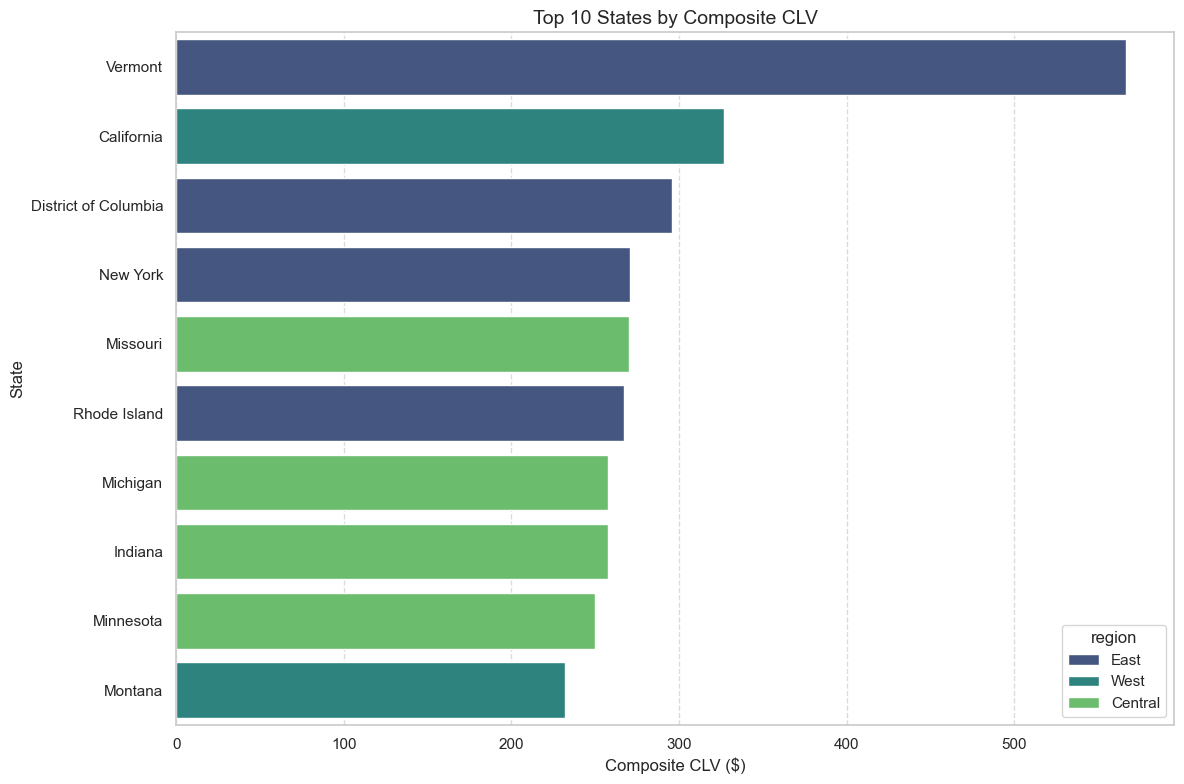

In [142]:
# 3. Top 10 States by CLV
plt.figure(figsize=(12, 8))
top_states = state_metrics.sort_values('composite_clv', ascending=False).head(10)
sns.barplot(
        x='composite_clv',
        y='state',
        hue='region',
        data=top_states,
        palette='viridis'
    )
plt.title('Top 10 States by Composite CLV', fontsize=14)
plt.xlabel('Composite CLV ($)', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7, axis='x')
plt.tight_layout()
plt.show()  # This displays the plot directly in VS Code


# State Quadrant Analysis: Discount Sensitivity vs. Profit Margin

This scatter plot positions each state based on profit margin and discount sensitivity.

**What it shows:**
- States positioned across four strategic quadrants
- How geography impacts profit and discount sensitivity
- Bubble size represents Traditional CLV in each state

**Quadrant Insights:**
- **Top-Right**: High Profit, Discount Responsive - Opportunity for premium pricing with strategic promotions
- **Top-Left**: Low Profit, Discount Responsive - Target for promotional campaigns to improve margins
- **Bottom-Right**: High Profit, Discount Resistant - Maintain premium positioning without discounting
- **Bottom-Left**: Low Profit, Discount Resistant - Requires fundamental strategy review

**Business applications:**
- Customize regional pricing strategies
- Target promotions in discount-responsive states
- Maintain premium pricing in discount-resistant, high-profit states
- Identify problematic regions requiring strategy adjustments

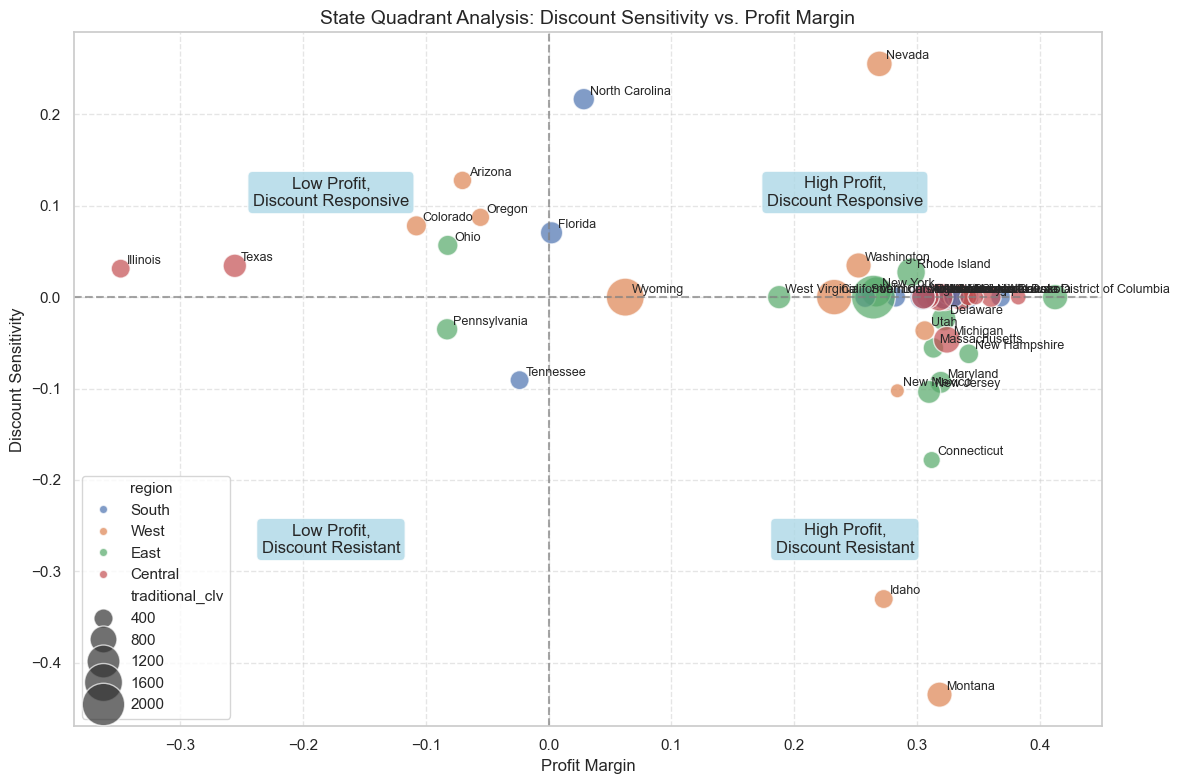

In [143]:
# 4. State Quadrant Analysis
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='profit_margin',
    y='discount_sensitivity',
    size='traditional_clv',
    hue='region',
    sizes=(100, 1000),
    alpha=0.7,
    data=state_metrics
)

# Add quadrant lines
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)

# Add labels for each state
for i, row in state_metrics.iterrows():
    plt.text(row['profit_margin'] + 0.005, 
             row['discount_sensitivity'] + 0.005, 
             row['state'], 
             fontsize=9)

# Add quadrant labels
plt.annotate('High Profit,\nDiscount Responsive', xy=(0.75, 0.75), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)
plt.annotate('Low Profit,\nDiscount Responsive', xy=(0.25, 0.75), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)
plt.annotate('High Profit,\nDiscount Resistant', xy=(0.75, 0.25), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)
plt.annotate('Low Profit,\nDiscount Resistant', xy=(0.25, 0.25), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)

plt.title('State Quadrant Analysis: Discount Sensitivity vs. Profit Margin', fontsize=14)
plt.xlabel('Profit Margin', fontsize=12)
plt.ylabel('Discount Sensitivity', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()  # This displays the plot directly in VS Code



# CLV Comparison across Subcategories

This bar chart compares three different CLV metrics across the top 10 most valuable subcategories.

**What it shows:**
- Highest-value subcategories ranked by composite CLV
- Comparison between traditional, profit-adjusted, and composite CLV metrics
- Relative performance differences across product categories

**Key insights:**
- Which subcategories deliver the highest customer lifetime value
- How profit adjustment impacts perceived subcategory value
- Category distribution among top performers

**Business applications:**
- Prioritize inventory and marketing for highest-CLV subcategories
- Identify subcategories with significant differences between traditional and adjusted CLV
- Develop targeted retention strategies for high-value product lines
- Guide product development investments toward high-performing categories

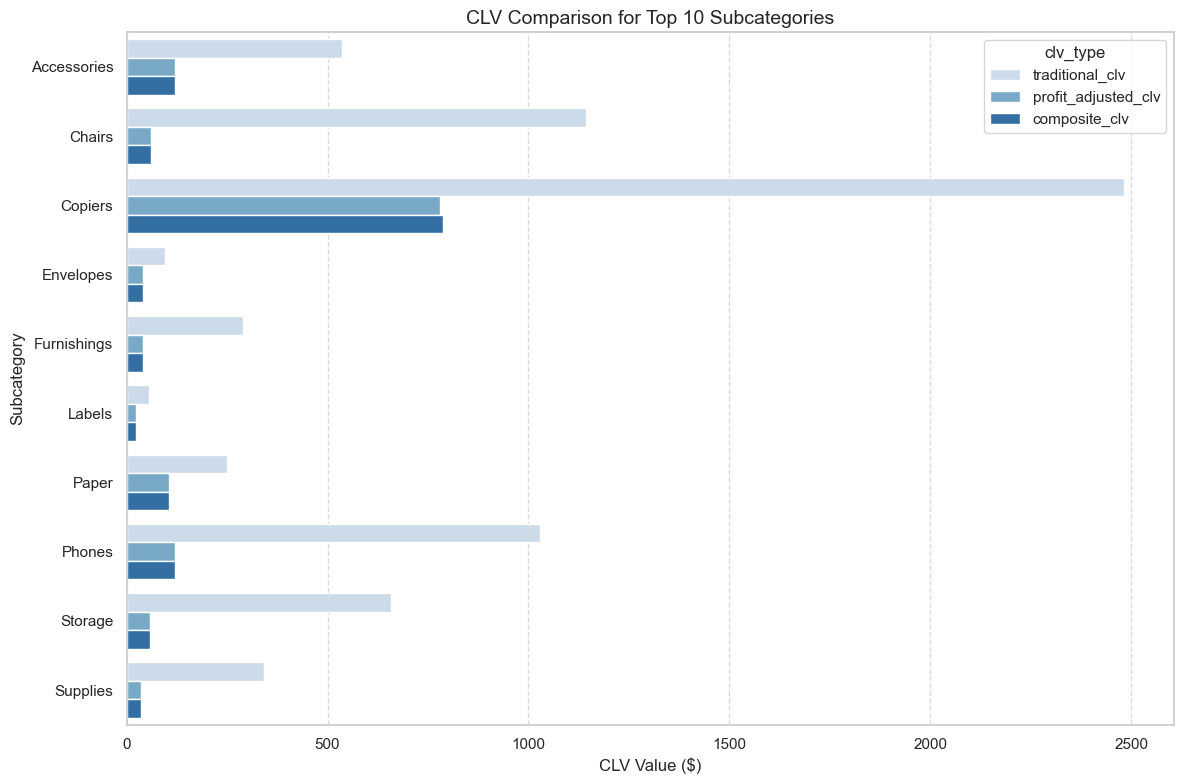

In [144]:
  # 5. CLV Comparison across Subcategories
  plt.figure(figsize=(12, 8))
  subcategory_clv_melted = pd.melt(
      subcategory_metrics,
      id_vars=['sub-category', 'category'],
      value_vars=['traditional_clv', 'profit_adjusted_clv', 'composite_clv'],
      var_name='clv_type',
      value_name='value'
  )
  
  # Take top 10 subcategories only
  top_subcats = subcategory_metrics.sort_values('composite_clv', ascending=False)['sub-category'].head(10).tolist()
  top_subcat_data = subcategory_clv_melted[subcategory_clv_melted['sub-category'].isin(top_subcats)]
  
  sns.barplot(
      x='value',
      y='sub-category',
      hue='clv_type',
      data=top_subcat_data,
      palette='Blues'
  )
  plt.title('CLV Comparison for Top 10 Subcategories', fontsize=14)
  plt.xlabel('CLV Value ($)', fontsize=12)
  plt.ylabel('Subcategory', fontsize=12)
  plt.grid(True, linestyle='--', alpha=0.7, axis='x')
  plt.tight_layout()
  plt.show()  # This displays the plot directly in VS Code
